In [182]:
from skimage.measure import label, regionprops
import numpy as np
import cv2
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import cv2
from skimage.measure import label, regionprops

def orientation_dilation_skimage(binary_mask, kernel_size=(20, 20), num_dilations=4):
    labeled_mask = label(binary_mask)
    props = regionprops(labeled_mask)
    
    dilated_mask = np.zeros_like(binary_mask, dtype=np.uint8)

    for prop in props:
        if prop.area < 10:  # skip tiny regions
            continue

        angle_rad = -prop.orientation + np.pi / 2 # Account for the coordinate system
        eccentricity = prop.eccentricity  # [0, 1]

        # Adjust axes based on eccentricity (0 = circle, 1 = line)
        w, h = kernel_size
        major_axis = w // 2
        minor_axis = max(1, int((h // 2) * (1 - eccentricity)))  # small for elongated regions

        # Create unrotated elliptical kernel
        kernel = np.zeros((h, w), dtype=np.uint8)
        cv2.ellipse(
            img=kernel,
            center=(w // 2, h // 2),
            axes=(major_axis, minor_axis),
            angle=np.degrees(angle_rad),  # Directly input the ellipse angle
            startAngle=0,
            endAngle=360,
            color=1,
            thickness=-1
        )

        # Dilate the region using the custom kernel
        region_mask = (labeled_mask == prop.label).astype(np.uint8)
        dilated = region_mask.copy()
        for _ in range(num_dilations):
            dilated = cv2.dilate(dilated, kernel)

        # Merge into the global mask
        dilated_mask = np.maximum(dilated_mask, dilated)

    # Final connected component labeling
    final_labels = label(dilated_mask > 0, connectivity=2)
    return np.max(final_labels) > 1, final_labels.astype(np.uint8), labeled_mask


def assign_labels_using_orientation_dilation(binary_mask, dilated_mask):
    labeled_mask = label(binary_mask)
    props = regionprops(labeled_mask)

    for prop in props:

        region_mask = (labeled_mask == prop.label).astype(np.uint8)
        dilated_region = cv2.bitwise_and(dilated_mask, dilated_mask, mask=region_mask)

        if np.any(dilated_region):
            labeled_mask[region_mask > 0] = np.max(dilated_region) + 1

    return labeled_mask

    

In [183]:
masks_path = "/home/jackson/research/data/tortuosity_study/QC_results/tortuosity_test_set_QC/usable_tissue_masks"

In [184]:
filenames = sorted(glob.glob(os.path.join(masks_path, "*.png")))

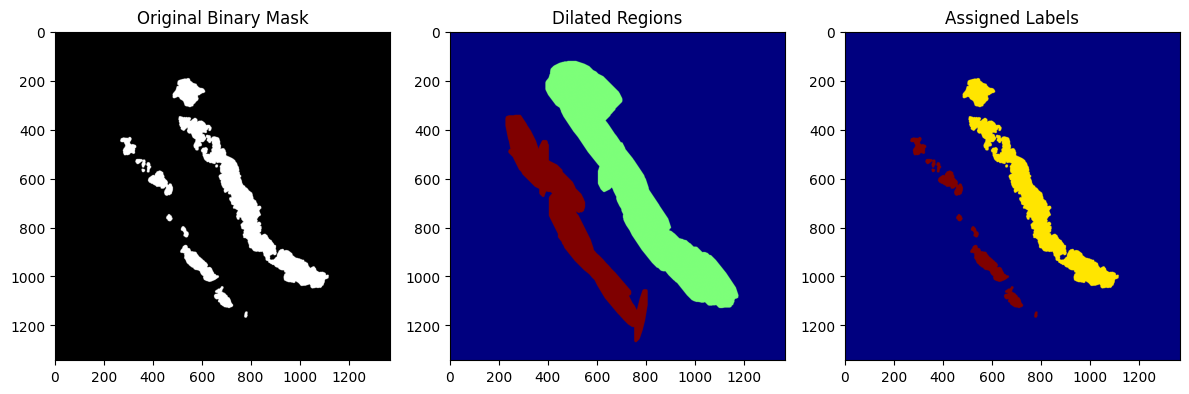

In [185]:
mask_path = filenames[91]
mask = Image.open(mask_path)
b = np.asarray(mask)
b = np.where(b > 0, 1, 0)
connected_comp, final_labels, labeled_mask = orientation_dilation_skimage(b, num_dilations=10)

labeled_mask = assign_labels_using_orientation_dilation(b, final_labels)
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(b, cmap='gray')
plt.title('Original Binary Mask')
plt.subplot(1, 3, 2)
plt.imshow(final_labels, cmap='jet')
plt.title('Dilated Regions')
plt.subplot(1, 3, 3)
plt.imshow(labeled_mask, cmap='jet')
plt.title('Assigned Labels')
plt.tight_layout()
plt.show()